In [1]:
import pandas as pd
from premise.geomap import Geomap
import time
from tqdm import tqdm
import brightway2 as bw
import bw2data as bd
import numpy as np
import pickle
import re
import pycountry

In [2]:
from config import *#some main key parameters needed.
from plotting import *
from mapping import *
from functions import *

## Description

In this script, we:

- Take the new IAM database containing steel facilities
  (generated in `3_create_additional_prospective_regionalized_dbs.ipynb`);
- Calcilate all LCA results of the facilities;
- Generate the main figures.

In [3]:
bw.projects.set_current(PROJECT_NAME) #Creating/accessing the project
DB_NAME_INIT,PROJECT_NAME

('ecoinvent-3.10-cutoff', 'lca_steel_sector_cbam')

In [4]:
calc_lca_impacts_future = False
contri_future=False
annotate_exc=False
db_to_modify = "steel_db_future_ccs"
# take the IMAGE scenario, 2C:
iam_model = 'remind'
new_iam_model_scenario = 'SSP2-PkBudg1150'
new_iam_scenario = f'{iam_model}_{new_iam_model_scenario}'
DB_TO_ASSESS = f"{db_to_modify}_{new_iam_scenario}"
DB_TO_ASSESS 

'steel_db_future_ccs_remind_SSP2-PkBudg1150'

In [5]:
steel_demand_remind_2040_prim = 724.45318
steel_demand_remind_2040_sec = 961.5875094
steel_demand_remind_2040 = steel_demand_remind_2040_prim + steel_demand_remind_2040_sec

steel_demand_image_2040_prim = 1446.449436
steel_demand_image_2040_sec = 702.041904
steel_demand_image_2040 = steel_demand_image_2040_prim+steel_demand_image_2040_sec

# we will have to apply a factor as the steel demand differs between the IAM scenarios.
factor_prod_vol = steel_demand_remind_2040/steel_demand_image_2040
factor_prod_vol_prim = steel_demand_remind_2040_prim/steel_demand_image_2040_prim
factor_prod_vol_sec = steel_demand_remind_2040_sec/steel_demand_image_2040_sec
factor_prod_vol_sec, factor_prod_vol_prim

(1.369701016308565, 0.500849294810745)

# 1. CCS scenario

In [6]:
acts = list(bw.Database(DB_TO_ASSESS))

file_path = "results/results_df_future_REMIND_ccs.pkl"

columns = ['name', 'year', 'unit', 'country', 'reference product','production volume',"database"]
columns.extend([f"lca_impact_{method[1]}" for method in MY_METHODS]) # for lca impcats of the h2 facilities
columns.extend([f"lca_impact_contri_{method[1]}" for method in MY_METHODS if 'climate change' in str(method)]) # for lca impcats of the h2 facilities

results_df_future_ccs = pd.DataFrame(columns=columns) #initialize df to store data in

start_idx=0

if annotate_exc:
    annotate_exchanges_with_cbam(
        db_name=DB_TO_ASSESS,
        define_scope_cbam_func=define_scope_cbam,
        cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL
    )
                    
# Loop over activities and calculate LCA impacts for each method
if calc_lca_impacts_future:  
    for i, act_sel in enumerate(tqdm(acts)):
        if i < start_idx:
            continue  # Skip until we reach the desired index
            
        db_name_exch = ""

        lca_scores = {}
        lca_scores_contri = {}

        for method in MY_METHODS:
            # Initialize LCA for the first method or reuse for subsequent methods
            if i == 0:
                lca = bw.LCA({act_sel: 1}, method=method)
                lca.lci()
                lca.lcia()
            else:
                if len(MY_METHODS)>1:
                    lca.switch_method(method)
                lca.redo_lcia({act_sel: 1})
            
            # Store the score for the current method
            lca_scores[f'lca_impact_{method[1]}'] = lca.score

            if 'climate change' in str(method) and contri_future:
                result_array = []
                for exc in act_sel.exchanges():
                    if exc['type'] == 'technosphere':
                        lca.redo_lcia({exc.input: exc['amount']})
                        result_array.append((exc['name'], lca.score, exc['scope'], exc['cbam'], exc['amount']))
                    elif exc['type'] == 'biosphere':
                        # Multiply amount by its CF
                        cf = lca.characterization_matrix[lca.biosphere_dict[exc.input], :].sum()
                        result_array.append((exc['name'], cf * exc['amount'], exc['scope'], exc['cbam'], exc['amount']))
    
                lca_scores_contri[f'lca_impact_contri_{method[1]}'] = result_array

        result = {
            'name': act_sel['name'],
            'reference product': act_sel['reference product'],
            'country':act_sel['location'],
            'location': act_sel['location'],
            'production volume':act_sel['production volume'], #(act_sel['production volume']*factor_prod_vol_sec 
                                  #if 'steel production, electric, low-alloyed, secondary steel' in act_sel['name'] else act_sel['production volume']*factor_prod_vol_prim),
            'unit': act_sel['unit'],
            "database": act_sel['database'],
            "initial name": act_sel['name'].split(" for facility in")[0],
            'comment': act_sel['comment'],
            'year': int(m.group(1)) if (m := re.search(r'\[(\d{4})\]', act_sel['name'])) else None,
            'latitude': act_sel['comment'].split("latitude:")[1].split(",")[0],
            'longitude': act_sel['comment'].split("longitude:")[1].split(",")[0],
            'power_source': act_sel['comment'].split("power source:")[1].split(",")[0],
        }
    
        # update the result dictionary with lca scores
        result.update(lca_scores)
        result.update(lca_scores_contri)

        # Convert the result to a DataFrame
        result = pd.DataFrame([result])
    
        # Concatenate the result DataFrame with the main DataFrame
        results_df_future_ccs = pd.concat([results_df_future_ccs, result], ignore_index=True)

    # Save the DataFrame as a pickle file
    results_df_future_ccs.to_pickle(file_path)
else:
    with open(file_path, 'rb') as file:
        results_df_future_ccs = pickle.load(file)        

# make lat and lon numeric
results_df_future_ccs['latitude'] = pd.to_numeric(results_df_future_ccs['latitude'], errors='coerce')
results_df_future_ccs['longitude'] = pd.to_numeric(results_df_future_ccs['longitude'], errors='coerce')

# Now, we also apply a function that excludes the transport exchanges we added, as not all steel will be imported to the EU
results_df_future_ccs["lca_impact_climate change_wo_transport"] = results_df_future_ccs['lca_impact_contri_climate change'].apply(sum_exchanges_wo_transport)
results_df_future_ccs["Plant_GHG_emissions_Mt_wo_transport"] = results_df_future_ccs['production volume']*results_df_future_ccs['lca_impact_climate change_wo_transport']

#results_df_future_ccs = pd.merge(results_df_future_ccs, df_countries, on='location') # add lat lon info
# Add a new column to the DataFrame to classify countries as European or Non-European
results_df_future_ccs['region'] = results_df_future_ccs['location'].apply(lambda x: 'European' if x in european_countries else 'Non-European')
results_df_future_ccs["Plant_GHG_emissions_Mt"] = results_df_future_ccs['production volume']*results_df_future_ccs['lca_impact_climate change']
results_df_future_ccs['commodity_type'] = results_df_future_ccs['initial name'].map(dict_types)
#exclude iron making
results_df_future_ccs = results_df_future_ccs[~results_df_future_ccs['initial name'].str.contains('iron', case=False, na=False)]
results_df_future_ccs.sort_values(by="Plant_GHG_emissions_Mt", ascending=False)

,name,year,unit,country,reference product,production volume,database,lca_impact_climate change,lca_impact_contri_climate change,location,initial name,comment,latitude,longitude,power_source,lca_impact_climate change_wo_transport,Plant_GHG_emissions_Mt_wo_transport,region,Plant_GHG_emissions_Mt,commodity_type
7,"BF-BOF+CCS, steel production, unalloyed for fa...",2040,kilogram,CN,"steel, unalloyed",84.780,steel_db_future_ccs_remind_SSP2-PkBudg1150,1.578589,"[(Carbon dioxide, fossil, 0.9939215651435116, ...",CN,"BF-BOF+CCS, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",27.814130,112.897377,grid,1.464813,124.186816,Non-European,133.832812,primary steel (BF-BOF-CCS)
38,"BF-BOF+CCS, steel production, unalloyed for fa...",2040,kilogram,CN,"steel, unalloyed",79.983,steel_db_future_ccs_remind_SSP2-PkBudg1150,1.578589,"[(Carbon dioxide, fossil, 0.9939215651435116, ...",CN,"BF-BOF+CCS, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",27.747782,111.967343,grid,1.464813,117.160110,Non-European,126.260318,primary steel (BF-BOF-CCS)
538,"BF-BOF+CCS, steel production, low-alloyed for ...",2040,kilogram,CN,"steel, low-alloyed",41.914,steel_db_future_ccs_remind_SSP2-PkBudg1150,1.848022,"[(Chromium III, 0.0, 1, True, 2.73861278752583...",CN,"BF-BOF+CCS, steel production, low-alloyed","< This dataset is from ecoinvent, modified by ...",37.752351,115.184798,grid,1.734245,72.689134,Non-European,77.457974,primary steel (BF-BOF-CCS)
85,"BF-BOF+CCS, steel production, unalloyed for fa...",2040,kilogram,CN,"steel, unalloyed",31.873,steel_db_future_ccs_remind_SSP2-PkBudg1150,1.578058,"[(Carbon dioxide, fossil, 0.9939215651435116, ...",CN,"BF-BOF+CCS, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",31.983146,120.638992,pv,1.464282,46.671051,Non-European,50.297458,primary steel (BF-BOF-CCS)
188,"BF-BOF+CCS, steel production, unalloyed for fa...",2040,kilogram,KR,"steel, unalloyed",22.349,steel_db_future_ccs_remind_SSP2-PkBudg1150,1.472670,"[(Carbon dioxide, fossil, 0.9939215651435116, ...",KR,"BF-BOF+CCS, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",34.920086,127.748650,grid,1.358893,30.369894,Non-European,32.912691,primary steel (BF-BOF-CCS)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,"steel production, electric, low-alloyed for fa...",2040,kilogram,IT,"steel, low-alloyed",0.737,steel_db_future_ccs_remind_SSP2-PkBudg1150,0.172980,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",IT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",44.388023,7.944998,grid,0.162453,0.119728,European,0.127486,secondary steel (EAF)
702,"steel production, electric, low-alloyed for fa...",2040,kilogram,IT,"steel, low-alloyed",0.737,steel_db_future_ccs_remind_SSP2-PkBudg1150,0.172980,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",IT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",45.645688,10.374305,grid,0.162453,0.119728,European,0.127486,secondary steel (EAF)
643,"steel production, electric, low-alloyed for fa...",2040,kilogram,IT,"steel, low-alloyed",0.614,steel_db_future_ccs_remind_SSP2-PkBudg1150,0.172980,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",IT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",37.438448,15.032870,grid,0.162453,0.099746,European,0.106209,secondary steel (EAF)
268,"steel production, electric, low-alloyed for fa...",2040,kilogram,FR,"steel, low-alloyed",0.614,steel_db_future_ccs_remind_SSP2-PkBudg1150,0.172980,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",FR,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",50.398171,3.561712,grid,0.162453,0.099746,European,0.106209,secondary steel (EAF)


In [7]:
results_df_future_ccs['commodity_type'].unique()

array(['secondary steel (EAF)', 'primary steel (BF-BOF-CCS)',
       'primary steel (DRI-EAF, H$_2$)'], dtype=object)

### consider primary and secondary steel from REMIND and correct for the production volumes

In [8]:
results_df_future_ccs.loc[
    results_df_future_ccs['commodity_type'] == 'secondary steel (EAF)', 
    'production volume'
] *= factor_prod_vol_sec

results_df_future_ccs.loc[
    results_df_future_ccs['commodity_type'] != 'secondary steel (EAF)', 
    'production volume'
] *= factor_prod_vol_prim

In [9]:
results_df_future_ccs[results_df_future_ccs['commodity_type'] == 'secondary steel (EAF)']['production volume'].sum(), results_df_future_ccs[results_df_future_ccs['commodity_type'] != 'secondary steel (EAF)']['production volume'].sum()

(961.5821620872323, 724.4534624790022)

In [10]:
total_emissions = results_df_future_ccs['Plant_GHG_emissions_Mt_wo_transport'].sum()
total_production = results_df_future_ccs['production volume'].sum()
emissions_intensity = total_emissions / total_production

print(f"Total GHG emissions (without transport): {total_emissions:.2f} Mt")
print(f"Total production volume: {total_production:.2f}")
print(f"Emissions intensity: {emissions_intensity:.2f} kgCO2-eq./kg steel")

Total GHG emissions (without transport): 2645.31 Mt
Total production volume: 1686.04
Emissions intensity: 1.57 kgCO2-eq./kg steel


### 1.1 plot CCS scenario

C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


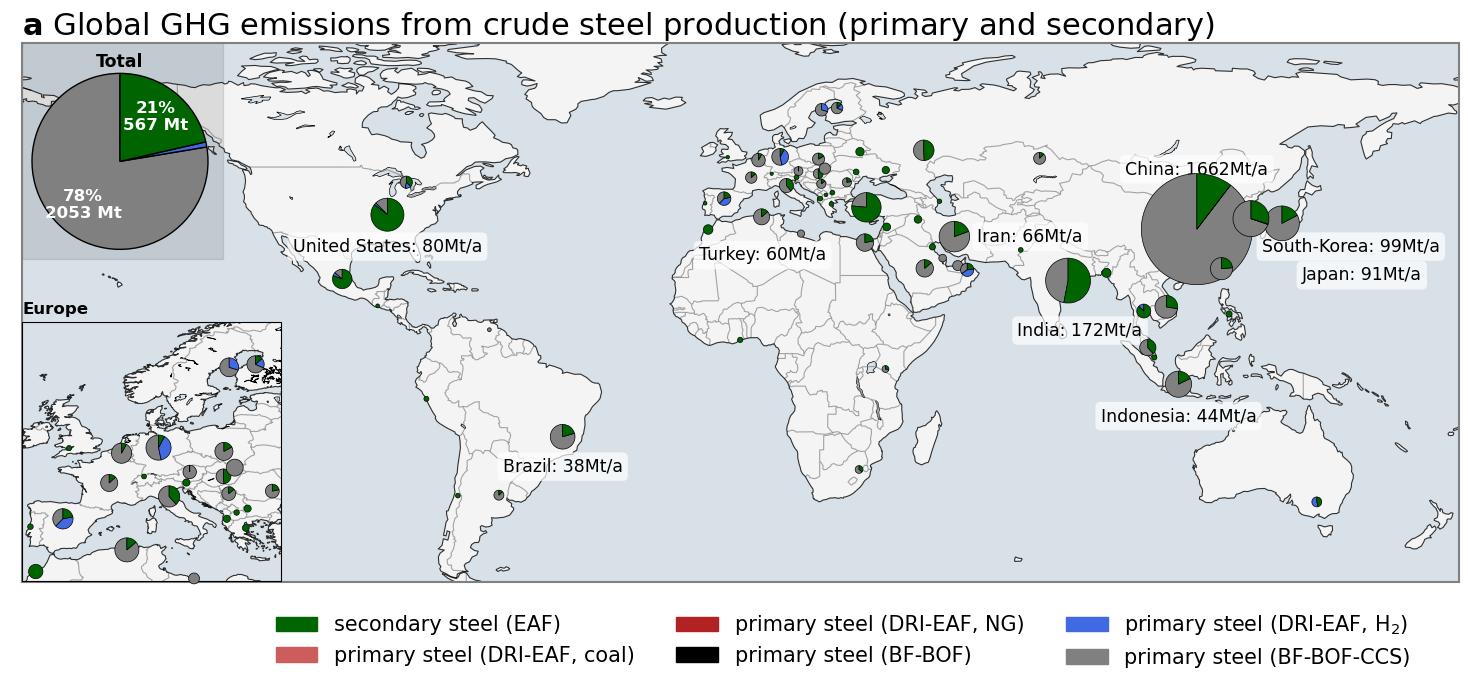

In [11]:
# List of titles and potential columns
titles = [r'$\mathbf{a}$ Global GHG emissions from crude steel production (primary and secondary)']

name_to_assess = "Plant_GHG_emissions_Mt_wo_transport"
pot_cols = [name_to_assess]
plot_steel_map(results_df_future_ccs, pot_cols, subplot=False, titles = titles, division_bubble=14, amount_show_bubble=35, 
               export_figure='REMIND/annual_global_steel_emissions_2040_ccs_REMIND', 
               dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +18),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (0, -19),
                           'Taiwan, Province of China'
                           : (-12, -19),
                        'Japan': (-13, -20),
                        #'Korea, Republic of': (+5, +45),
                           'South-Korea': (-7, -25),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (-12, +26),
                        'United States': (-8, 0),
                        'Taiwan': (-5, -5),
                           'Egypt': (-14, 0)
                          }, 
              pos_legend_false_subplot = (57, -5.5))

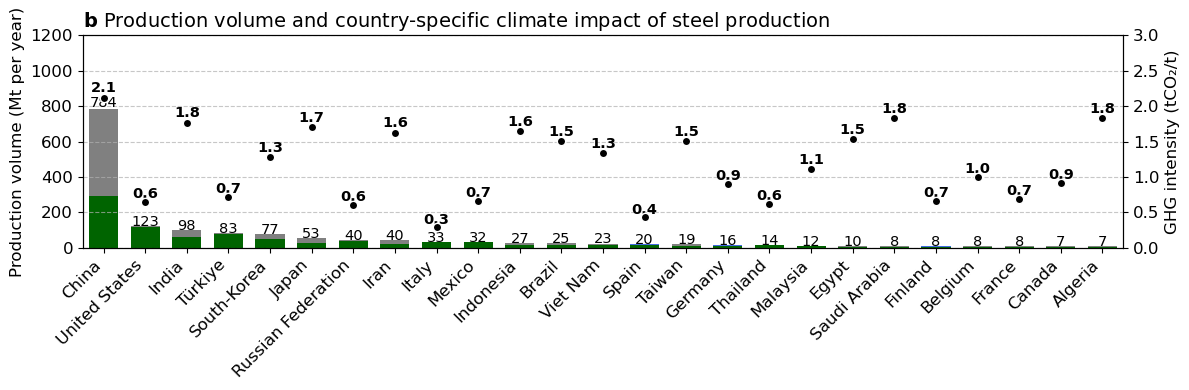

In [12]:
for col in ['production volume']:
    plot_steel_production(results_df_future_ccs, production_col=col, export_figure='REMIND/prod_fig_intensity_REMIND_ccs')

C:\Users\terlouw_t\Documents\Projects\TRANSIENCE\Steel_CBAM\plotting.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


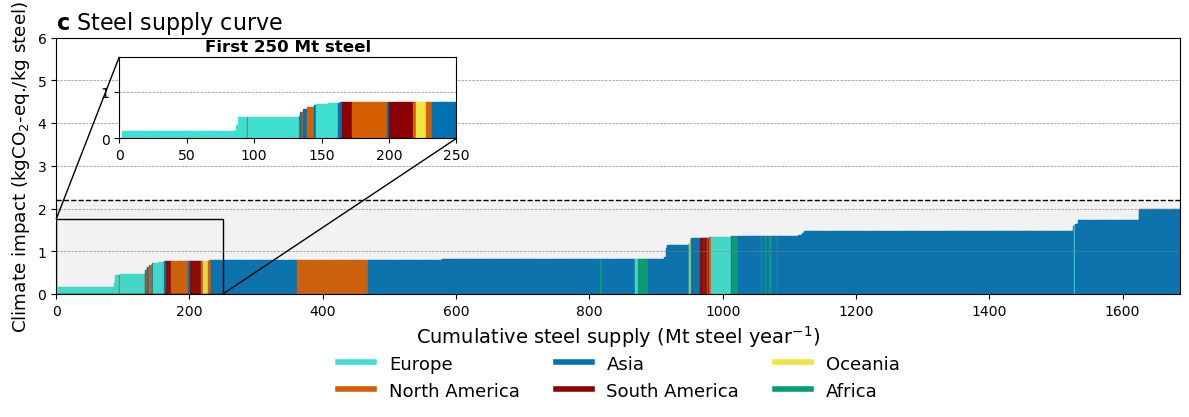

In [13]:
plot_steel_supply_curve(
    results_df=results_df_future_ccs,
    get_continent_func=get_continent,
    color_mapping=dict_color_fig_2_c,
    emission_thresholds={'BF-BOF (2025)': 2.2},
    output_path="figs/REMIND/steel_supply_curve_REMIND_ccs.png"
)

# 2. H2-DRI-EAF scenario

In [14]:
db_to_modify = "steel_db_future"
DB_TO_ASSESS_H2 = f"{db_to_modify}_{new_iam_scenario}"
DB_TO_ASSESS_H2 

'steel_db_future_remind_SSP2-PkBudg1150'

In [15]:
acts = list(bw.Database(DB_TO_ASSESS_H2))

file_path = "results/results_df_future_h2s_REMIND.pkl"

columns = ['name', 'year', 'unit', 'country', 'reference product','production volume',"database"]
columns.extend([f"lca_impact_{method[1]}" for method in MY_METHODS]) # for lca impcats of the h2 facilities
columns.extend([f"lca_impact_contri_{method[1]}" for method in MY_METHODS if 'climate change' in str(method)]) # for lca impcats of the h2 facilities

results_df_future_h2 = pd.DataFrame(columns=columns) #initialize df to store data in

start_idx=0

if annotate_exc:
    annotate_exchanges_with_cbam(
        db_name=DB_TO_ASSESS_H2,
        define_scope_cbam_func=define_scope_cbam,
        cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_EXCL
    )
                    
# Loop over activities and calculate LCA impacts for each method
if calc_lca_impacts_future:  
    for i, act_sel in enumerate(tqdm(acts)):
        if i < start_idx:
            continue  # Skip until we reach the desired index
            
        db_name_exch = ""

        lca_scores = {}
        lca_scores_contri = {}

        for method in MY_METHODS:
            # Initialize LCA for the first method or reuse for subsequent methods
            if i == 0:
                lca = bw.LCA({act_sel: 1}, method=method)
                lca.lci()
                lca.lcia()
            else:
                if len(MY_METHODS)>1:
                    lca.switch_method(method)
                lca.redo_lcia({act_sel: 1})
            
            # Store the score for the current method
            lca_scores[f'lca_impact_{method[1]}'] = lca.score

            if 'climate change' in str(method) and contri_future:
                result_array = []
                for exc in act_sel.exchanges():
                    if exc['type'] == 'technosphere':
                        lca.redo_lcia({exc.input: exc['amount']})
                        result_array.append((exc['name'], lca.score, exc['scope'], exc['cbam'], exc['amount']))
                    elif exc['type'] == 'biosphere':
                        # Multiply amount by its CF
                        cf = lca.characterization_matrix[lca.biosphere_dict[exc.input], :].sum()
                        result_array.append((exc['name'], cf * exc['amount'], exc['scope'], exc['cbam'], exc['amount']))
    
                lca_scores_contri[f'lca_impact_contri_{method[1]}'] = result_array

        result = {
            'name': act_sel['name'],
            'reference product': act_sel['reference product'],
            'country':act_sel['location'],
            'location': act_sel['location'],
            'production volume':act_sel['production volume'], #(act_sel['production volume']*factor_prod_vol_sec 
                                  #if 'steel production, electric, low-alloyed, secondary steel' in act_sel['name'] else act_sel['production volume']*factor_prod_vol_prim),
            'unit': act_sel['unit'],
            "database": act_sel['database'],
            "initial name": act_sel['name'].split(" for facility in")[0],
            'comment': act_sel['comment'],
            'year': int(m.group(1)) if (m := re.search(r'\[(\d{4})\]', act_sel['name'])) else None,
            'latitude': act_sel['comment'].split("latitude:")[1].split(",")[0],
            'longitude': act_sel['comment'].split("longitude:")[1].split(",")[0],
            'power_source': act_sel['comment'].split("power source:")[1].split(",")[0],
        }
    
        # update the result dictionary with lca scores
        result.update(lca_scores)
        result.update(lca_scores_contri)

        # Convert the result to a DataFrame
        result = pd.DataFrame([result])
    
        # Concatenate the result DataFrame with the main DataFrame
        results_df_future_h2 = pd.concat([results_df_future_h2, result], ignore_index=True)

    # Save the DataFrame as a pickle file
    results_df_future_h2.to_pickle(file_path)
else:
    with open(file_path, 'rb') as file:
        results_df_future_h2 = pickle.load(file)        

# make lat and lon numeric
results_df_future_h2['latitude'] = pd.to_numeric(results_df_future_h2['latitude'], errors='coerce')
results_df_future_h2['longitude'] = pd.to_numeric(results_df_future_h2['longitude'], errors='coerce')

# Now, we also apply a function that excludes the transport exchanges we added, as not all steel will be imported to the EU
results_df_future_h2["lca_impact_climate change_wo_transport"] = results_df_future_h2['lca_impact_contri_climate change'].apply(sum_exchanges_wo_transport)
results_df_future_h2["Plant_GHG_emissions_Mt_wo_transport"] = results_df_future_h2['production volume']*results_df_future_h2['lca_impact_climate change_wo_transport']

#results_df_future_h2 = pd.merge(results_df_future_h2, df_countries, on='location') # add lat lon info
# Add a new column to the DataFrame to classify countries as European or Non-European
results_df_future_h2['region'] = results_df_future_h2['location'].apply(lambda x: 'European' if x in european_countries else 'Non-European')
results_df_future_h2["Plant_GHG_emissions_Mt"] = results_df_future_h2['production volume']*results_df_future_h2['lca_impact_climate change']
results_df_future_h2['commodity_type'] = results_df_future_h2['initial name'].map(dict_types)
#exclude iron making
results_df_future_h2 = results_df_future_h2[~results_df_future_h2['initial name'].str.contains('iron', case=False, na=False)]
results_df_future_h2.sort_values(by="Plant_GHG_emissions_Mt", ascending=False)

,name,year,unit,country,reference product,production volume,database,lca_impact_climate change,lca_impact_contri_climate change,location,initial name,comment,latitude,longitude,power_source,lca_impact_climate change_wo_transport,Plant_GHG_emissions_Mt_wo_transport,region,Plant_GHG_emissions_Mt,commodity_type
94,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,CN,"H2-DRI-EAF steel, unalloyed",84.780,steel_db_future_remind_SSP2-PkBudg1150,0.669461,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",27.814130,112.897377,grid,0.555684,47.110889,Non-European,56.756885,"primary steel (DRI-EAF, H$_2$)"
120,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,CN,"H2-DRI-EAF steel, unalloyed",79.983,steel_db_future_remind_SSP2-PkBudg1150,0.669461,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",27.747782,111.967343,grid,0.555684,44.445273,Non-European,53.545482,"primary steel (DRI-EAF, H$_2$)"
619,"H2-DRI-EAF, steel production, low-alloyed for ...",2040,kilogram,CN,"H2-DRI-EAF steel, low-alloyed",41.914,steel_db_future_remind_SSP2-PkBudg1150,0.974463,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, low-alloyed","< This dataset is from ecoinvent, modified by ...",37.752351,115.184798,grid,0.860686,36.074812,Non-European,40.843652,"primary steel (DRI-EAF, H$_2$)"
361,"steel production, electric, low-alloyed for fa...",2040,kilogram,IN,"steel, low-alloyed",11.670,steel_db_future_remind_SSP2-PkBudg1150,2.103614,"[(steel production, electric, low-alloyed, 1.9...",IN,"steel production, electric, low-alloyed",Geography: Data collected from integrated ste...,21.112377,72.647304,grid,1.989837,23.221402,Non-European,24.549177,secondary steel (EAF)
387,"H2-DRI-EAF, steel production, unalloyed for fa...",2040,kilogram,CN,"H2-DRI-EAF steel, unalloyed",31.873,steel_db_future_remind_SSP2-PkBudg1150,0.584224,"[(Benzene, 0.0, 1, True, 3.410321381705713e-07...",CN,"H2-DRI-EAF, steel production, unalloyed","< This dataset is from ecoinvent, modified by ...",31.983146,120.638992,pv,0.470447,14.994552,Non-European,18.620960,"primary steel (DRI-EAF, H$_2$)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,"steel production, electric, low-alloyed for fa...",2040,kilogram,IT,"steel, low-alloyed",0.737,steel_db_future_remind_SSP2-PkBudg1150,0.172980,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",IT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",45.645688,10.374305,grid,0.162453,0.119728,European,0.127486,secondary steel (EAF)
116,"steel production, electric, low-alloyed for fa...",2040,kilogram,IT,"steel, low-alloyed",0.737,steel_db_future_remind_SSP2-PkBudg1150,0.172980,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",IT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",44.388023,7.944998,grid,0.162453,0.119728,European,0.127486,secondary steel (EAF)
574,"steel production, electric, low-alloyed for fa...",2040,kilogram,FR,"steel, low-alloyed",0.614,steel_db_future_remind_SSP2-PkBudg1150,0.172980,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",FR,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",50.398171,3.561712,grid,0.162453,0.099746,European,0.106209,secondary steel (EAF)
51,"steel production, electric, low-alloyed for fa...",2040,kilogram,IT,"steel, low-alloyed",0.614,steel_db_future_remind_SSP2-PkBudg1150,0.172980,"[(Antimony ion, 0.0, 1, True, 1.80934972445754...",IT,"steel production, electric, low-alloyed","This dataset has been modified by `premise`, a...",37.438448,15.032870,grid,0.162453,0.099746,European,0.106209,secondary steel (EAF)


### consider primary and secondary steel from REMIND and correct for the production volumes

In [16]:
results_df_future_h2.loc[
    results_df_future_h2['commodity_type'] == 'secondary steel (EAF)', 
    'production volume'
] *= factor_prod_vol_sec

results_df_future_h2.loc[
    results_df_future_h2['commodity_type'] != 'secondary steel (EAF)', 
    'production volume'
] *= factor_prod_vol_prim

In [17]:
results_df_future_h2[results_df_future_h2['commodity_type'] == 'secondary steel (EAF)']['production volume'].sum(), results_df_future_h2[results_df_future_h2['commodity_type'] != 'secondary steel (EAF)']['production volume'].sum()

(961.5821620872323, 724.4534624790022)

In [18]:
total_emissions = results_df_future_h2['Plant_GHG_emissions_Mt_wo_transport'].sum()
total_production = results_df_future_h2['production volume'].sum()
emissions_intensity = total_emissions / total_production

print(f"Total GHG emissions (without transport): {total_emissions:.2f} Mt")
print(f"Total production volume: {total_production:.2f}")
print(f"Emissions intensity: {emissions_intensity:.2f} kgCO2-eq./kg steel")

Total GHG emissions (without transport): 1477.03 Mt
Total production volume: 1686.04
Emissions intensity: 0.88 kgCO2-eq./kg steel


C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


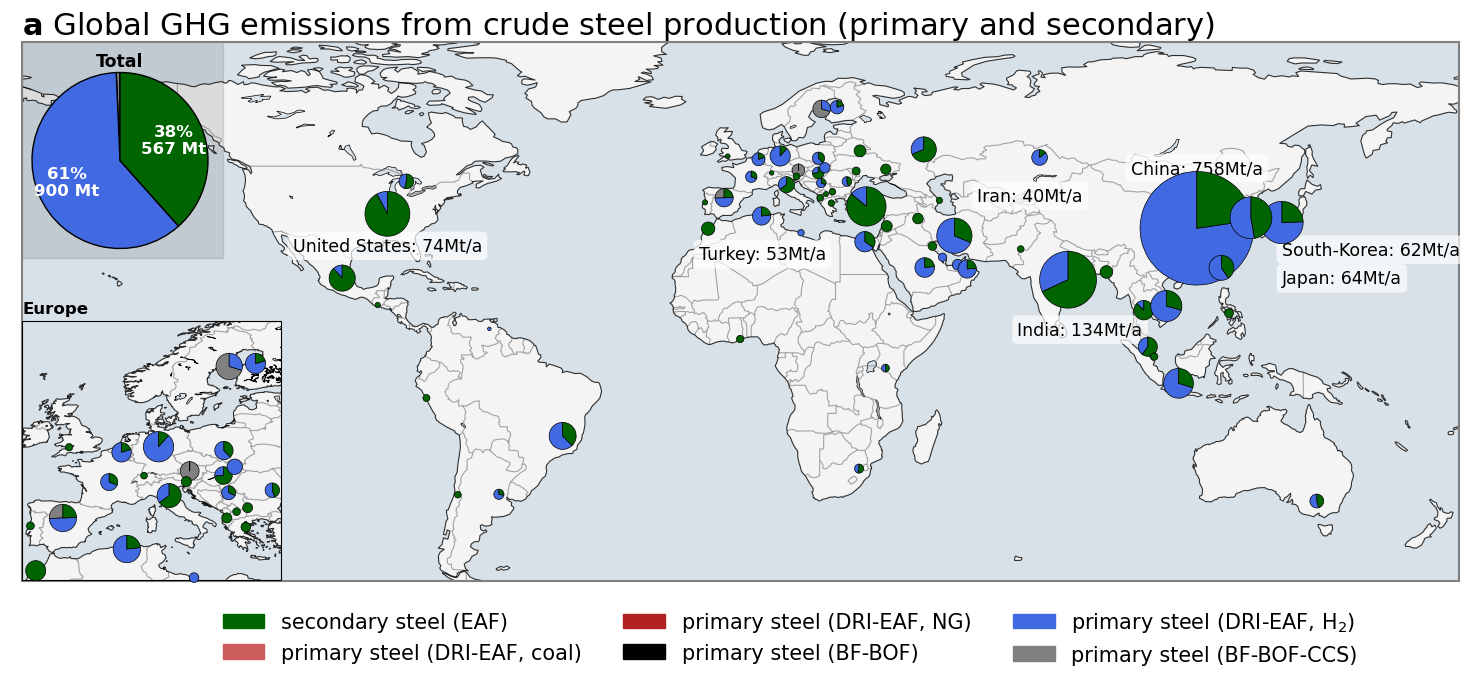

In [19]:
# List of titles and potential columns
titles = [r'$\mathbf{a}$ Global GHG emissions from crude steel production (primary and secondary)']

name_to_assess = "Plant_GHG_emissions_Mt_wo_transport"
pot_cols = [name_to_assess]
plot_steel_map(results_df_future_h2, pot_cols, subplot=False, titles = titles, division_bubble=10, amount_show_bubble=35, 
               export_figure='REMIND/annual_global_steel_emissions_2040_h2_REMIND', 
               dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +18),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (10, -19),
                           'Taiwan, Province of China'
                           : (-12, -19),
                        'Japan': (-14, -15),
                        #'Korea, Republic of': (+5, +45),
                           'South-Korea': (-8, -30),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (-12, +26),
                        'United States': (-8, 0),
                        'Taiwan': (-5, -5),
                           'Egypt': (-14, 0)
                          }, 
              pos_legend_false_subplot = (60, -6))

In [20]:
results_df_future_h2[name_to_assess].sum()

1477.0291316240884

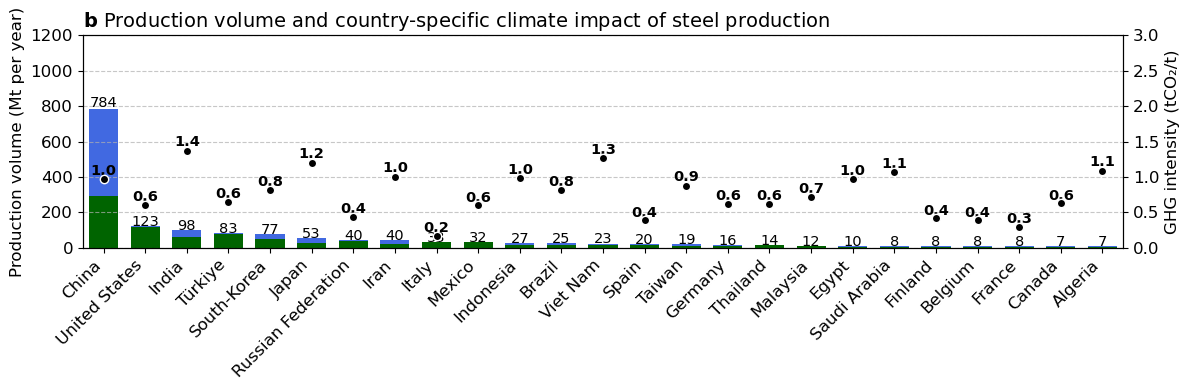

In [21]:
for col in ['production volume']:
    plot_steel_production(results_df_future_h2, production_col=col, export_figure='REMIND/prod_fig_intensity_REMIND_h2')

C:\Users\terlouw_t\Documents\Projects\TRANSIENCE\Steel_CBAM\plotting.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


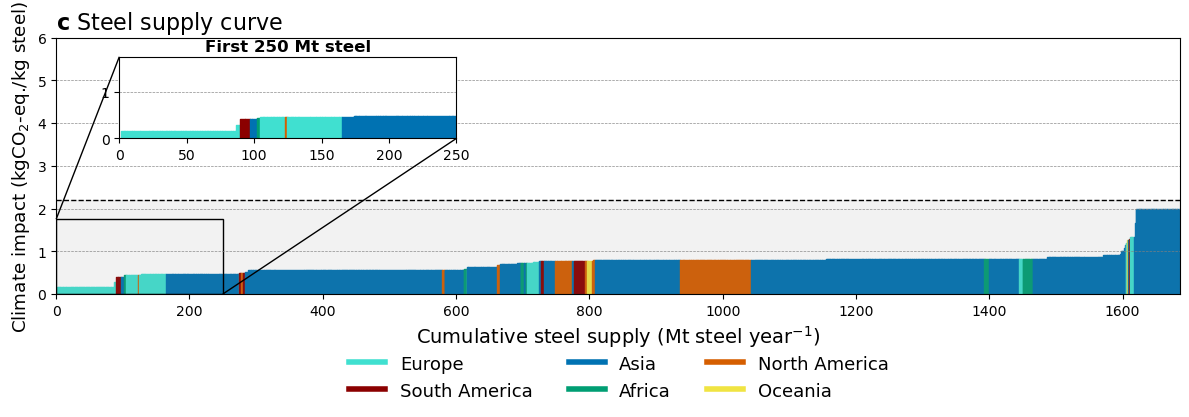

In [22]:
plot_steel_supply_curve(
    results_df=results_df_future_h2,
    get_continent_func=get_continent,
    color_mapping=dict_color_fig_2_c,
    emission_thresholds={'BF-BOF (2025)': 2.2},
    output_path="figs/REMIND/steel_supply_curve_REMIND_h2.png"
)